## Tobit regression with TensorFlow

Tobit regression fits the following model for non-negative data $ y $: 

$  y({\bf X}) = \max (0, w_0 + \sum_{i=1}^{N} w_i X_i + w_{N+1} \cdot \varepsilon) $  

Here $ X_i $ are predictors, $ \varepsilon \sim N(0,1) $ is a standard Gaussian noise, and $ w_{N+1} $ is the noise
volatility (standard deviation).

Our problem is to fit parameters $ N+2 $ parameters $ w_{i} $ for $ i = 0, \ldots, N+1 $ to the observed set of pairs $ \left({\bf X}_i, y_i \right) $  

We use synthetic data with known parameters to learn how to implement Tobit Regression in TensorFlow. 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

In [2]:
# utility function  to reset the TF graph to the same state each time
def reset_graph(seed=42):
    # to make results reproducible across runs
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    

## 1. Tobit Regression class

In [3]:
class Tobit_Regression:
    
    def __init__(self, n_features, learning_rate=0.005, L=0):
        
        self.input = tf.placeholder(tf.float32, [None, n_features], name="Input")
        self.target = tf.placeholder(tf.float32, [None, 1], name="Target")
        
        # the first weight is for the intercept, the last one is for a square root of the noise std 
        self.weights = tf.Variable(tf.random_normal([n_features + 2, 1]))
        
        # Augmented data matrix is obtained by adding a column of ones to the data matrix
        self.data_plus_bias = tf.concat([tf.ones([tf.shape(self.input)[0], 1]), self.input], axis=1)

        
        # MLE for Tobit regression 
        # noise volatility is obtained as a square of the last weight to ensure positivity 
        self.sigma = 0.0001 + tf.square(self.weights[-1])
        # self.sigma = tf.constant(0.09834529)
        
        
        X = self.data_plus_bias
        Y = self.target
        XjBeta = tf.matmul(self.data_plus_bias[:, :], self.weights[:-1])
    
        masked = tf.greater(Y, L)
        Indicator = tf.cast(masked, tf.float32)

        gauss = tf.distributions.Normal(loc=0.0, scale=1.0)
        
        term1 = tf.multiply(Indicator, tf.log(0.00001 + (1 / self.sigma) * gauss.prob((Y - XjBeta)/self.sigma)))
        term2 = tf.multiply((tf.ones_like(Indicator) - Indicator), tf.log(0.00001 + 1 - gauss.cdf((XjBeta - L) / self.sigma)))
        self.loss = - tf.reduce_mean(term1 + term2)
        

        # Use Adam optimization for training
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss), 
                           -self.loss)
        
        # prediction made from the model: Use a ReLU neuron!
        self.output = tf.nn.relu(tf.matmul(self.data_plus_bias[:, :], self.weights[:-1]))
        
        # Check the output L1-norm error  
        self.output_L1_error = tf.reduce_mean(tf.abs(self.target - self.output))
        
        

    
    def generate_data(n_points,
                      n_features,
                      weights,
                      noise_std):

        # Bounds of [-1,1] in space of n_points x n_features
        bias = np.ones(n_points).reshape((-1,1))
        low = - np.ones((n_points,n_features),'float')
        high = np.ones((n_points,n_features),'float')

        # simulated features are uniformally distributed on [-1,1].
        # The size n_points x n_features of array X is inferred by broadcasting of 'low' and 'high'
        X = np.random.uniform(low=low, high=high)
        
        # simulated noise
        noise = np.random.normal(size=(n_points, 1))
        
        # outputs    
        Y = weights[0] * bias + np.dot(X, weights[1:]).reshape((-1,1)) + noise_std * noise

        # truncate negative values of Y    
        np.clip(Y, a_min=0, a_max=None, out=Y)

        return (X, Y)
    

In [4]:
reset_graph()

def main():
    
    n_points = 5000
    
    n_features = 3
    learning_rate = 0.05
    
    # n_features + 1 weights (one for a constant feature)
    data_weights = np.array([-0.25, 0.5, 0.2, .1]) 
    noise_std = 0.1
    
    # Make data
    (X,Y) = Tobit_Regression.generate_data(n_points=n_points,
                                n_features=n_features,
                                weights=data_weights,
                               noise_std=noise_std)
    
    # split to the train and test set
    train_test_split = 4  # 1/4 of the data is used for a test
    
    n_test = int(n_points/4)
    n_train = n_points - n_test
    
    X_train = X[:n_train,:]
    Y_train = Y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    Y_test = Y[n_train:].reshape((-1,1))
    
    # create an instance of the Tobit Regression class  
    model = Tobit_Regression(n_features=n_features, 
                 learning_rate=learning_rate)

    # train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for i in range(0, 1000):
            (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
                model.input: X_train,
                model.target: Y_train
                })
        
    
        # predictions for the test set
        output, std_model = sess.run([model.output, model.sigma], feed_dict={
            model.input: X_test})
        
        output_L1_error = sess.run(model.output_L1_error,
                                   feed_dict={model.input: X_test,
                                   model.target: Y_test})

    
        # Results
        print('Loss:', loss)
        print('Model fitted weights:')
        print(weights[:-1])
        print('Fitted noise_std: ', std_model) # std_model = weights[-1]**2     
        print('Test_L1_error: = ', output_L1_error)
        
        # Plot a projection of test prediction on the first two predictors
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
        ax.scatter(X_test[:,1], X_test[:,2], output.reshape([-1,1]), s=1, c="#FF0000")
        plt.xlabel('X_1')
        plt.ylabel('X_2')
        plt.show()
    

Loss: 0.13414356
Model fitted weights:
[[-0.24247044]
 [ 0.49173045]
 [ 0.1982799 ]
 [ 0.09300663]]
Fitted noise_std:  [0.09834529]
Test_L1_error: =  0.019833894


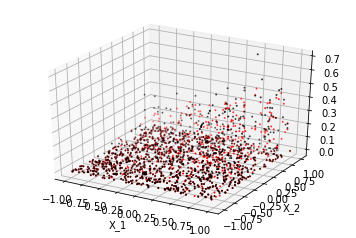

In [5]:
if __name__ == "__main__":
    main()

## 2. Use the model for real finance data.

### Try the Tobit Regression for two setting:
1. Take all events of bank failures, plus about equal number of records for nonfailed banks.
2. Take all failed banks, and all records for non-failed banks.

Try to see if you can remove some predictors to have comparable accuracy to what you got with the full set of predictors.

Report your suggested set of final predictors, and test-set prediction accuracy averaged over 10 independent splits of data into a train and test sets.

In [6]:
import pandas as pd
df = pd.read_hdf('df_FDIC_learn.h5',key='df')
predictors = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'core_deposits_to_TA',
'brokered_deposits_to_TA', 'liquid_assets_to_TA','FDIC_assessment_base_n',
'term_spread', 'stock_mkt_growth', 'bbb_spread_change']
dependent_variable = ['closing_cost', 'default_within_1Y']
fields = predictors + dependent_variable
df = df[fields]
print(df.shape)
df.head(5)

(37754, 13)


log_TA  NI_to_TA  Equity_to_TA  NPL_to_TL  \
IDRSSD date                                                      
2376   2001-03-31  1.082729  0.189800      0.268764  -0.828529   
       2001-06-30  1.090718  0.124079      0.289033  -0.828529   
       2001-09-30  1.125763  0.233606      0.282388  -0.822694   
       2001-12-31  1.137426  0.185885      0.250620  -0.822575   
       2002-03-31  1.162194  0.278015      0.230698  -0.625391   

                   core_deposits_to_TA  brokered_deposits_to_TA  \
IDRSSD date                                                       
2376   2001-03-31             0.860159                -0.182939   
       2001-06-30             0.824206                -0.182939   
       2001-09-30             0.683495                -0.182939   
       2001-12-31             0.613027                -0.182939   
       2002-03-31             0.477106                -0.182939   

                   liquid_assets_to_TA  FDIC_assessment_base_n  term_spread  \
IDRSSD date                                                                   
2376   2001-03-31             0.796870               -0.030591    -0.493078   
       2001-06-30             0.728834               -0.030385    -0.493078   
       2001-09-30             0.792894               -0.029315    -0.214985   
       2001-12-31             0.908698               -0.028902     1.268177   
       2002-03-31             0.975240               -0.028075     1.268177   

                   stock_mkt_growth  bbb_spread_change  closing_cost  \
IDRSSD date                                                            
2376   2001-03-31          0.736292          -0.095070           NaN   
       2001-06-30          0.736292          -0.095070           NaN   
       2001-09-30         -2.155401           0.161152           NaN   
       2001-12-31         -1.706992           0.161152           NaN   
       2002-03-31         -1.706992           0.161152           NaN   

                   default_within_1Y  
IDRSSD date                           
2376   2001-03-31                0.0  
       2001-06-30                0.0  
       2001-09-30                0.0  
       2001-12-31                0.0  
       2002-03-31                0.0

In [7]:
df_positive = df.loc[df['default_within_1Y'] != 0]
df_positive = df_positive.loc[df['closing_cost'] > 0]
print("Default events number is", df_positive.shape[0])

Default events number is 1362


In [8]:
df_negative = df[~df.isin(df_positive).all(1)]
print("Non-default events number is", df_negative.shape[0])
df_negative_sample = df_negative.head(1362)

Non-default events number is 36392


## 2.1.1 Analyze the first setting

Take all events of bank failures, plus about equal number of records for nonfailed banks.

In [9]:
# Create a new dataframe including all events of bank failures plus about equal number of records for nonfailed banks.
df_1 = pd.concat([df_positive, df_negative_sample])
df_1 = df_1.replace(np.nan, 0)
n_points = df_1.shape[0]
print('Data size for setting 1 is ' + str(n_points) + '.')
X = df_1[predictors].as_matrix()
Y = df_1['closing_cost'].as_matrix()
df_1.head()

Data size for setting 1 is 2724.


log_TA   NI_to_TA  Equity_to_TA  NPL_to_TL  \
IDRSSD date                                                       
2451   2009-09-30 -1.012492  -1.929218     -0.764122   0.382829   
       2009-12-31 -1.020469   0.541829     -0.656119   0.491166   
       2010-03-31 -1.129330  -3.662149     -0.851665   1.178994   
3953   2011-06-30 -0.199142  -0.083199     -0.647791   5.658201   
       2011-09-30 -0.749985 -19.011474     -1.424126  10.382015   

                   core_deposits_to_TA  brokered_deposits_to_TA  \
IDRSSD date                                                       
2451   2009-09-30            -1.569285                -0.182939   
       2009-12-31            -1.501730                -0.182939   
       2010-03-31            -0.989003                -0.182939   
3953   2011-06-30             0.536171                -0.119856   
       2011-09-30             0.736629                -0.049552   

                   liquid_assets_to_TA  FDIC_assessment_base_n  term_spread  \
IDRSSD date                                                                   
2451   2009-09-30            -0.884187               -0.050756     1.175479   
       2009-12-31            -0.717317               -0.050779     1.082782   
       2010-03-31            -1.141375               -0.050946     1.082782   
3953   2011-06-30            -1.486156               -0.048106     0.897386   
       2011-09-30            -0.844589               -0.050121     0.155806   

                   stock_mkt_growth  bbb_spread_change  closing_cost  \
IDRSSD date                                                            
2451   2009-09-30          1.644225          -3.682177        6651.0   
       2009-12-31         -1.520331           0.417374        6651.0   
       2010-03-31         -1.520331           0.417374        6651.0   
3953   2011-06-30         -0.132752          -0.095070        8725.0   
       2011-09-30         -2.083458           1.698484        8725.0   

                   default_within_1Y  
IDRSSD date                           
2451   2009-09-30                1.0  
       2009-12-31                1.0  
       2010-03-31                1.0  
3953   2011-06-30                1.0  
       2011-09-30                1.0

In [10]:
# split to the train and test set
train_test_split = 10  # 1/10 of the data is used for a test
    
n_test = n_points//20
n_train = n_points //2 - n_test

# print splitting nodes.
print(n_train)
print(n_points //2)
print(n_test)
print(n_points - n_test)

1226
1362
136
2588


(2452, 11) (272, 11)
Loss: -5.8128333
Model fitted weights:
[[-3.3645146 ]
 [-1.3055583 ]
 [-0.25570717]
 [ 0.48426104]
 [-0.2515969 ]
 [ 0.5390056 ]
 [ 1.3366581 ]
 [ 0.94270754]
 [-1.8085256 ]
 [-0.33588836]
 [-0.09454684]
 [-0.36061913]]
Fitted noise_std:  [0.8747333]
Test_L1_error: =  24313.023


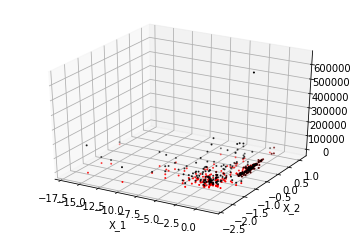

In [11]:
X_train = X[np.r_[:1226, 1362:2588]]
Y_train = Y[np.r_[:1226, 1362:2588]].reshape((-1,1))

X_test = np.r_[X[1226:1362], X[2588:]]
Y_test = np.r_[Y[1226:1362], Y[2588:]].reshape((-1,1))
print(X_train.shape, X_test.shape)

# create an instance of the Tobit Regression class
model = Tobit_Regression(n_features=len(predictors), learning_rate=0.05)

# train the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
        
    for i in range(0, 1000):
        (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
                                       model.input: X_train,
                                       model.target: Y_train})
        
    # predictions for the test set
    output, std_model = sess.run([model.output, model.sigma], feed_dict={
            model.input: X_test})
        
    output_L1_error = sess.run(model.output_L1_error,
                                feed_dict={model.input: X_test,
                                model.target: Y_test})

    # Results
    print('Loss:', loss)
    print('Model fitted weights:')
    print(weights[:-1])
    print('Fitted noise_std: ', std_model) # std_model = weights[-1]**2     
    print('Test_L1_error: = ', output_L1_error)
        
    # Plot a projection of test prediction on the first two predictors
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
    ax.scatter(X_test[:,1], X_test[:,2], output.reshape([-1,1]), s=1, c="#FF0000")
    plt.xlabel('X_1')
    plt.ylabel('X_2')
    plt.show()

## 2.1.2 Try to delete paramter(s) to achieve comparable accuracy.

The weight on 'stock_mkt_growth' is comparatively low.

Try to delete this parameter.

(2452, 10)
(272, 10)
Loss: -5.812814
Model fitted weights:
[[-2.2246425 ]
 [-1.9868926 ]
 [-0.597586  ]
 [ 0.58467656]
 [-0.38275763]
 [ 0.60895216]
 [ 1.4950944 ]
 [ 1.5377096 ]
 [ 1.1467171 ]
 [-0.6494625 ]
 [-0.16176873]]
Fitted noise_std:  [0.30102023]
Test_L1_error: =  24312.977


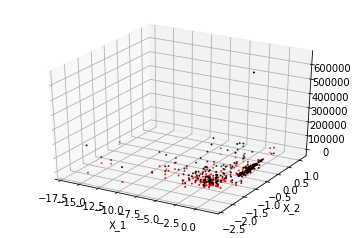

In [12]:
reset_graph(seed=42)

X = df_1[predictors]
X = X.drop('stock_mkt_growth', 1).as_matrix()
Y = df_1['closing_cost'].as_matrix()

X_train = X[np.r_[:1226, 1362:2588]]
Y_train = Y[np.r_[:1226, 1362:2588]].reshape((-1,1))
print(X_train.shape)

X_test = np.r_[X[1226:1362], X[2588:]]
Y_test = np.r_[Y[1226:1362], Y[2588:]].reshape((-1,1))
print(X_test.shape)

    
# create an instance of the Tobit Regression class
model = Tobit_Regression(n_features=len(predictors)-1, learning_rate=0.05)

# train the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
        
    for i in range(0, 1000):
        (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
                                       model.input: X_train,
                                       model.target: Y_train,
        })
        
    
    # predictions for the test set
    output, std_model = sess.run([model.output, model.sigma], feed_dict={
            model.input: X_test})
        
    output_L1_error = sess.run(model.output_L1_error,
                                feed_dict={model.input: X_test,
                                model.target: Y_test})

    
    # Results
    print('Loss:', loss)
    print('Model fitted weights:')
    print(weights[:-1])
    print('Fitted noise_std: ', std_model) # std_model = weights[-1]**2     
    print('Test_L1_error: = ', output_L1_error)
        
    # Plot a projection of test prediction on the first two predictors
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
    ax.scatter(X_test[:,1], X_test[:,2], output.reshape([-1,1]), s=1, c="#FF0000")
    plt.xlabel('X_1')
    plt.ylabel('X_2')
    plt.show()

## 2.2.1 Analyze the second setting.

Take all failed banks, and all records for non-failed banks.

In [13]:
# Create a new dataframe including all events of bank failures plus all records for nonfailed banks.
df_2 = pd.concat([df_positive, df_negative])
df_2 = df_2.replace(np.nan, 0)
n_points = df_2.shape[0]
print('Data size for setting 2 is ' + str(n_points) + '.')
X = df_2[predictors].as_matrix()
Y = df_2['closing_cost'].as_matrix()

Data size for setting 2 is 37754.


In [14]:
# split to the train and test set
train_test_split = 10  # 1/10 of the data is used for a test
    
n_test = n_points//20
n_train = n_points //2 - n_test
print(n_train)
print(n_points //2)
print(n_test)
print(n_points - n_test)

16990
18877
1887
35867


(33980, 11) (3774, 11)
Loss: -0.59157044
Model fitted weights:
[[-2.9197395 ]
 [-0.19707021]
 [ 0.00575102]
 [-0.11383574]
 [-0.06293368]
 [ 0.07763852]
 [ 0.01437617]
 [ 0.17772095]
 [ 0.02185822]
 [-0.1032676 ]
 [-0.05836546]
 [-0.15267304]]
Fitted noise_std:  [0.64321375]
Test_L1_error: =  979.5093


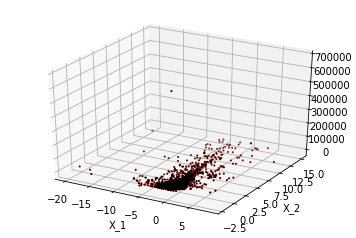

In [15]:
reset_graph(seed=42)

X_train = X[np.r_[:16990, 18877:35867]]
Y_train = Y[np.r_[:16990, 18877:35867]].reshape((-1,1))

X_test = np.r_[X[16990:18877], X[35867:]]
Y_test = np.r_[Y[16990:18877], Y[35867:]].reshape((-1,1))
print(X_train.shape, X_test.shape)

    
# create an instance of the Tobit Regression class
model = Tobit_Regression(n_features=len(predictors), learning_rate=0.05)

# train the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
        
    for i in range(0, 1000):
        (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
                                       model.input: X_train,
                                       model.target: Y_train})
        
    
    # predictions for the test set
    output, std_model = sess.run([model.output, model.sigma], feed_dict={
            model.input: X_test})
        
    output_L1_error = sess.run(model.output_L1_error,
                                feed_dict={model.input: X_test,
                                model.target: Y_test})

    
    # Results
    print('Loss:', loss)
    print('Model fitted weights:')
    print(weights[:-1])
    print('Fitted noise_std: ', std_model) # std_model = weights[-1]**2     
    print('Test_L1_error: = ', output_L1_error)
        
    # Plot a projection of test prediction on the first two predictors
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
    ax.scatter(X_test[:,1], X_test[:,2], output.reshape([-1,1]), s=1, c="#FF0000")
    plt.xlabel('X_1')
    plt.ylabel('X_2')
    plt.show()

## 2.2.2 Try to delete paramter(s) to achieve comparable accuracy.

Weights on 'Equity_to_TA', 'liquid_assets_to_TA' and 'stock_mkt_growth' are comparatively low.

Try to delete these two parameters.

(2452, 8)
(35302, 8)
Loss: -5.812813
Model fitted weights:
[[-2.7177196 ]
 [-0.7665082 ]
 [-0.05323284]
 [-0.07507379]
 [ 0.64407057]
 [ 0.9382233 ]
 [ 0.50943774]
 [-0.34836274]
 [-0.20919998]]
Fitted noise_std:  [0.01344883]
Test_L1_error: =  1577.6864


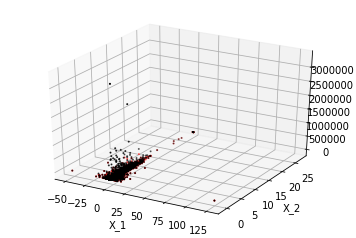

In [23]:
reset_graph(seed=42)
predictors = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'core_deposits_to_TA',
'brokered_deposits_to_TA', 'liquid_assets_to_TA','FDIC_assessment_base_n',
'term_spread', 'stock_mkt_growth', 'bbb_spread_change']
delete = ['Equity_to_TA', 'liquid_assets_to_TA', 'stock_mkt_growth']
X = df_2[predictors]
X = X.drop(delete, 1).as_matrix()
Y = df_2['closing_cost'].as_matrix()

X_train = X[np.r_[:1226, 1362:2588]]
Y_train = Y[np.r_[:1226, 1362:2588]].reshape((-1,1))
print(X_train.shape)

X_test = np.r_[X[1226:1362], X[2588:]]
Y_test = np.r_[Y[1226:1362], Y[2588:]].reshape((-1,1))
print(X_test.shape)

    
# create an instance of the Tobit Regression class
model = Tobit_Regression(n_features=len(predictors)-len(delete), learning_rate=0.05)

# train the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
        
    for i in range(0, 1000):
        (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
                                       model.input: X_train,
                                       model.target: Y_train,
        })
        
    
    # predictions for the test set
    output, std_model = sess.run([model.output, model.sigma], feed_dict={
            model.input: X_test})
        
    output_L1_error = sess.run(model.output_L1_error,
                                feed_dict={model.input: X_test,
                                model.target: Y_test})

    
    # Results
    print('Loss:', loss)
    print('Model fitted weights:')
    print(weights[:-1])
    print('Fitted noise_std: ', std_model) # std_model = weights[-1]**2     
    print('Test_L1_error: = ', output_L1_error)
        
    # Plot a projection of test prediction on the first two predictors
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
    ax.scatter(X_test[:,1], X_test[:,2], output.reshape([-1,1]), s=1, c="#FF0000")
    plt.xlabel('X_1')
    plt.ylabel('X_2')
    plt.show()

### Report my suggested set of final predictors and test-set prediction accuracy averaged over 10 independent splits of data into a train and test sets.

In [28]:
reset_graph(seed=42)

predictors = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'core_deposits_to_TA',
'brokered_deposits_to_TA', 'liquid_assets_to_TA','FDIC_assessment_base_n',
'term_spread', 'stock_mkt_growth', 'bbb_spread_change']
df = df.replace(np.nan, 0)
n_points = df.shape[0]
print(n_points)
delete = ['Equity_to_TA', 'liquid_assets_to_TA', 'stock_mkt_growth']
predictors = [x for x in predictors if x not in delete]
print("My suggested set of final predictors:")
print(predictors)
X = df[predictors].as_matrix()
Y = df['closing_cost'].as_matrix().reshape((-1,1))

37754
My suggested set of final predictors:
['log_TA', 'NI_to_TA', 'NPL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 'FDIC_assessment_base_n', 'term_spread', 'bbb_spread_change']


In [29]:
n_epochs = 10
batch_size = 3000
n_batches = int(np.ceil(n_points / batch_size))
batch_size = 2000
def fetch_batch(batch_index, batch_size):
    np.random.seed(batch_index * n_batches + batch_index)
    indices = np.random.randint(n_points, size=batch_size)
    X_batch_train = X[indices[:1500]]
    Y_batch_train = Y[indices[:1500]]
    X_batch_test = X[indices[1500:]]
    Y_batch_test = Y[indices[1500:]]
    return X_batch_train, Y_batch_train, X_batch_test, Y_batch_test

# create an instance of the Tobit Regression class
model = Tobit_Regression(n_features=len(predictors), learning_rate=0.05)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = []
    output_L1_errors = []
    for batch_index in range(n_batches):
        X_batch_train, Y_batch_train, X_batch_test, Y_batch_test = fetch_batch(batch_index, batch_size)
        for i in range(0, 1000):
            (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
                                           model.input: X_batch_train,
                                           model.target: Y_batch_train,
            })
        losses.append(loss)
        
        # predictions for the test set
        output, std_model = sess.run([model.output, model.sigma], feed_dict={
                            model.input: X_batch_test})
        
        output_L1_error = sess.run(model.output_L1_error,
                                    feed_dict={model.input: X_batch_test,
                                    model.target: Y_batch_test})
        output_L1_errors.append(output_L1_error)
    
    # Results
    print('Average Loss:', np.mean(losses))   
    print('Average est_L1_error: = ', np.mean(output_L1_errors))


Average Loss: -0.5579234
Average est_L1_error: =  6080.1357
